# Fitting IM Lup

This code runs the MCMC simulation to calculate the best fit parameters for the disk. It uses the logprob function from logprob_parallel.py.

In [1]:
import shutil
import getpass
import tempfile
from copy import deepcopy
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as c
from astropy.io import fits
import emcee

import dsharp_helper as dh
import dsharp_opac as do
import disklab
from gofish import imagecube

/Users/franceschi/mysims/DISKLAB/disklab/diskradial.py:18: UserWarning: numba not available, opacity calculation will be very slow
  warnings.warn('numba not available, opacity calculation will be very slow')


In [2]:
from helper_functions import get_profile_from_fits
from helper_functions import get_normalized_profiles
from helper_functions import make_opacs
from helper_functions import chop_forward_scattering
from helper_functions import make_disklab2d_model
from helper_functions import write_radmc3d

In [3]:
import logP_testing as logP
import astropy.constants as c
import astropy.units as u
import pickle

In [4]:
from radmc3dPy import image

In [5]:
au = c.au.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value

In [6]:
if getpass.getuser() == 'birnstiel':
    radmc3d_exec = Path('~/.bin/radmc3d').expanduser()
else:
    radmc3d_exec = Path('~/bin/radmc3d').expanduser()

### Set options

In [7]:
disk = 'IMLup'

**Disklab Grid**

In [8]:
nr = 100
rin = 0.1 * au
rout = 400 * au  # 400au from avenhaus paper  #DSHARP Huang 2018 says 290 au

**physical parameters**

In [9]:
r_c = 300 * au  # ??
alpha = 1e-3

mstar = 10.**dh.sources.loc[disk]['log M_star/M_sun'] * M_sun
lstar = 10.**dh.sources.loc[disk]['log L_star/L_sun'] * L_sun
tstar = 10.**dh.sources.loc[disk]['log T_eff/ K']
rstar = np.sqrt(lstar / (4 * np.pi * c.sigma_sb.cgs.value * tstar**4))

PA = dh.sources.loc[disk]['PA']
inc = dh.sources.loc[disk]['inc']
dpc = dh.sources.loc[disk]['distance [pc]']

**ALMA data**

In [10]:
fname_mm_obs = dh.get_datafile(disk)
clip = 2 * rout / au / dpc
lam_mm = 0.125
RMS_jyb = 14e-6

**Sphere data**

To deproject the scattered light image, we will need to know where the scattering surface is. This is based on the Avenhaus et al. 2018 paper. In `imagecube` this surface can be defined with `z0` and `psi` such that its height $z$ is at

$\mathsf{z = z0 \, \left(\frac{r}{arcsec}\right)^{psi}}\, arcsec$

In [11]:
# disk surface parameters

z0 = 0.2
psi = 1.27

# observed wavelength
lam_sca = 1.65e-4

# fname_sca_obs_orig = 'Qphi_IMLup.fits'
fname_sca_obs_orig = 'IM_Lup_reducedRob_median_Hband_12.25mas.fits'

 # pixel size of the sphere image, converted to degree
pixelsize = (12.5*u.mas).to('deg').value

# the "beam" assumed in the radial profile calculation
beam_sca = (0.040, 0.040, 0.0)

# RMS of the observations
RMS_sca = ...

## ALMA data 

Get the radial profile from the image

In [12]:
x_mm_obs, y_mm_obs, dy_mm_obs = get_profile_from_fits(
    fname_mm_obs,
    clip=clip,
    inc=inc, PA=PA,
    z0=0.0,
    psi=0.0)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Compare against the DSHARP profile

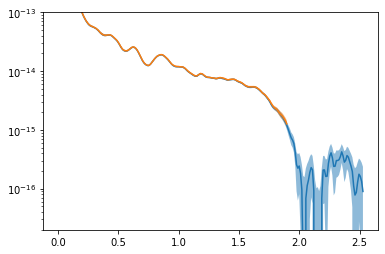

In [13]:
ds_prof = dh.get_profile(disk)

f, ax = plt.subplots()
ax.semilogy(x_mm_obs, y_mm_obs)
ax.fill_between(x_mm_obs, y_mm_obs - dy_mm_obs, y_mm_obs + dy_mm_obs, alpha=0.5)

ax.semilogy(ds_prof['r_as'], ds_prof['I_nu'])
ax.fill_between(ds_prof['r_as'], ds_prof['I_nu_l'], ds_prof['I_nu_u'], alpha=0.5)

ax.set_ylim(2e-17, 1e-13);

### SPHERE data

The image does not contain all the required info, so we make a copy of the fits file and modify that one

In [14]:
fname_sca_obs = fname_sca_obs_orig.replace('.fits', '_mod.fits')
shutil.copy(fname_sca_obs_orig, fname_sca_obs)

fits.setval(fname_sca_obs, 'cdelt1', value=-pixelsize)
fits.setval(fname_sca_obs, 'cdelt2', value=pixelsize)
fits.setval(fname_sca_obs, 'crpix1', value=fits.getval(fname_sca_obs_orig, 'naxis1') // 2 + 0.5)
fits.setval(fname_sca_obs, 'crpix2', value=fits.getval(fname_sca_obs_orig, 'naxis2') // 2 + 0.5)
fits.setval(fname_sca_obs, 'crval1', value=0.0)
fits.setval(fname_sca_obs, 'crval2', value=0.0)
fits.setval(fname_sca_obs, 'crval3', value=1.65e-4)
fits.setval(fname_sca_obs, 'BUNIT', value='JY/PIXEL')

In [15]:
# read it with imagecube and derive profiles
profiles_sca_obs = get_normalized_profiles(
    fname_sca_obs,
    clip=clip,
    inc=inc,
    PA=PA,
    z0=z0,
    psi=psi,
    beam=beam_sca,
    )

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


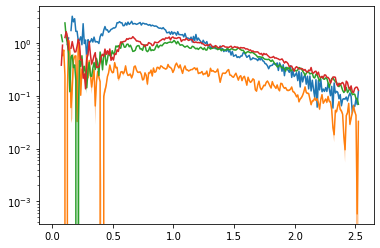

In [16]:
f, ax = plt.subplots()

for i, key in enumerate(profiles_sca_obs.keys()):
    profile = profiles_sca_obs[key]
    x = profile['x']
    y = profile['y']
    dy = profile['dy']
    mask = profile['mask']

    ax.semilogy(x, y, c=f'C{i}')
    ax.fill_between(x, y - dy, y + dy, fc=f'C{i}', alpha=0.5)

## Opacities

define the wavelength, size, and angle grids then calculate opacities and store them in a local file, if it doesn't exist yet.  
**Careful, that takes of the order of >2h**

In [17]:
n_lam = 200 # number of wavelength points
n_a = 15 # number of particle sizes
n_theta = 181 # number of angles in the scattering phase function
porosity = 0.3

# wavelength and particle sizes grids

lam_opac = np.logspace(-5, 1, n_lam)
a_opac = np.logspace(-5, 1, n_a)

# make opacities if necessary

opac_dict = make_opacs(a_opac, lam_opac, porosity=porosity, n_theta=n_theta)
fname_opac = opac_dict['filename']

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
reading from file dustkappa_IMLUP_p30.npz


This part chops the very-forward scattering part of the phase function. This part is basically the same as no scattering, but are treated by the code as a scattering event. By cutting this part out of the phase function, we avoid those non-scattering scattering events. This needs to recalculate $\kappa_{sca}$ and $g$.

In [18]:
fname_opac_chopped = fname_opac.replace('.', '_chopped.')

k_sca_nochop = opac_dict['k_sca']
g_nochop = opac_dict['g']

zscat, zscat_nochop, k_sca, g = chop_forward_scattering(opac_dict)

opac_dict['k_sca'] = k_sca
opac_dict['zscat'] = zscat
opac_dict['g'] = g

rho_s = opac_dict['rho_s']
m = 4 * np.pi / 3 * rho_s * a_opac**3

do.write_disklab_opacity(fname_opac_chopped, opac_dict)

/Users/franceschi/mysims/dsharp_opac/dsharp_opac/dsharp_opac.py:2001: UserWarning: Maximum error of 1.4e+11%: above error tolerance
  warnings.warn('Maximum error of {:.2g}%: above error tolerance'.format(error_max * 100))


## Put all options in a dictionary

In [19]:
options = {}

options['disk'] = disk
options['PA'] = PA
options['inc'] = inc
options['distance'] = dpc
options['clip'] = clip
options['lam_mm'] = lam_mm
options['RMS_jyb'] = RMS_jyb
options['mstar'] = mstar
options['lstar'] = lstar
options['tstar'] = tstar
options['rstar'] = rstar

# set the mm observables

options['x_mm_obs'] = x_mm_obs
options['y_mm_obs'] = y_mm_obs
options['dy_mm_obs'] = dy_mm_obs
options['fname_mm_obs'] = fname_mm_obs

# set options used in the scattered light image

options['z0'] = z0
options['psi'] = psi
options['lam_sca'] = lam_sca
options['fname_sca_obs'] = fname_sca_obs
options['beam_sca'] = beam_sca
options['RMS_sca'] = RMS_sca

# get the scattered light data

options['profiles_sca_obs'] = profiles_sca_obs

# name of the opacities file

options['fname_opac'] = fname_opac_chopped

# get the disklab model parameters

options['nr'] = nr
options['rin'] = rin
options['r_c'] = r_c
options['rout'] = rout
options['alpha'] = alpha

pickle.dump(options, open("options.p", "wb"))

## Emcee part

here we define some inputs and initial parameter sets for the optimization

In [20]:
# defining number of walkers
nwalkers = 25
ndim     = 7

# setting the priors for some parameters instead of letting them be uniform randoms between (0.1)

sigma_coeff_0   = 10**((np.random.rand(nwalkers)-0.5)*4)
others_0        = np.random.rand(ndim-3,nwalkers)
d2g_coeff_0     = (np.random.rand(nwalkers)+0.5) / 100
d2g_exp_0       = (np.random.rand(nwalkers)-0.5) 

# the input matrix of priors
p0 = np.vstack((sigma_coeff_0,others_0, d2g_coeff_0, d2g_exp_0)).T

**Here comes the rest of `MCMC_parallelized.py`, not cleaned up yet**

In [21]:
procs = 1

if procs > 1:
    # Parallelizing the simluation and running it for 250 iterations
    with Pool(processes=procs) as pool:
        sampler1 = emcee.EnsembleSampler(nwalkers, ndim, logP.logP, args=[options], pool=pool)
        sampler1.run_mcmc(p0, 250)
else:
    sampler1 = emcee.EnsembleSampler(nwalkers, ndim, logP.logP, args=[options])
    sampler1.run_mcmc(p0, 250)

print(sampler1.iteration)    

print('step2')
sampler2 = deepcopy(sampler1)
sampler2.log_prob_fn = None
with open('sampler.pickle', 'wb') as fid:
    pickle.dump(sampler2, fid)

disk to star mass ratio = 0.0078
>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>                             VERSION 2.0
>>>   
>>>                   (c) 2008-2020 Cornelis Dullemond
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>                        the RADMC-3D forum:
>>>               http://radmc3d.ita.uni-heidelberg.de/phpbb/
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    ================================================================
>>>   
>>>    Number of processors:            8


/Users/franceschi/mysims/IMLup/Til/logP_testing.py:240: UserWarning: observed and simulated radial profile grids are not equal
  warnings.warn('observed and simulated radial profile grids are not equal')
Traceback (most recent call last):
  File "/anaconda3/envs/dipsy/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/franceschi/mysims/IMLup/Til/logP_testing.py", line 104, in logP
    write_radmc3d(disk2d, lam_opac, temp_path, show_plots=False)
  File "/Users/franceschi/mysims/IMLup/Til/helper_functions.py", line 463, in write_radmc3d
    rmcd = disklab.radmc3d.get_radmc3d_arrays(disk2d, showplots=show_plots)
  File "/Users/franceschi/mysims/DISKLAB/disklab/radmc3d/radmc3d_helper.py", line 828, in get_radmc3d_arrays
    ref = refine_inner_edge(r1, ri1, rho_sph, temp, kappa_dust, nr_add=nr_add, showplots=showplots)
  File "/Users/franceschi/mysims/DISKLAB/disklab/radmc3d/radmc3d_helper.py", line 1010, in r

IndexError: index 100 is out of bounds for axis 0 with size 100

In [ ]:
!jupyter nbconvert --to python testing.ipynb

<hr>
<h1 style="color:red;">Testing area</h1>

In [ ]:
testparameters =[
    7.0,
    0.730,
    0.558,
    0.017,
    0.625,
    0.008,
    0.050,
    ]

In [ ]:
import logP_testing
from importlib import reload
reload(logP_testing)

In [ ]:
logp_value, debug_info = logP.logP(testparameters, options, debug=True)

# Analyze the output

In [ ]:
iq_sca_sim = debug_info['iq_sca_sim']
iq_sca_obs = debug_info['iq_sca_obs']
iq_mm_sim = debug_info['iq_mm_sim']
iq_mm_obs = debug_info['iq_mm_obs']

#### Scattered light images

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
vmin = 5e-8
vmax = 20 * vmin
ax[0].imshow(iq_sca_sim.data, extent=iq_sca_sim.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[1].imshow(iq_sca_obs.data, extent=iq_sca_obs.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2])

ax[0].axis('off')
ax[1].axis('off')
f.subplots_adjust(wspace=0)
f.savefig('sca.pdf', transparent=True, bbox_inches='tight')

#### Radio Images

In [ ]:
im_cgs_sim = iq_mm_sim.data * iq_mm_sim.pix_per_beam / iq_mm_sim.beamarea_str * 1e-23
im_cgs_obs = iq_mm_obs.data / iq_mm_sim.beamarea_str * 1e-23

f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
vmin = RMS_jyb * 1e-23 / iq_mm_obs.beamarea_str # the RMS from dsharp (Jy/beam) to CGS conversion
vmax = 20 * vmin
ax[0].imshow(im_cgs_sim, extent=iq_mm_sim.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[1].imshow(im_cgs_obs, extent=iq_mm_obs.extent, vmin=vmin, vmax=vmax, origin='lower')
ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2]);

ax[0].axis('off')
ax[1].axis('off')
f.subplots_adjust(wspace=0)
f.savefig('mm.pdf', transparent=True, bbox_inches='tight')

#### Plot profiles

In [ ]:
x_mm_sim = debug_info['x_mm_sim']
y_mm_sim = debug_info['y_mm_sim']
dy_mm_sim = debug_info['dy_mm_sim']

x_sca_sim = debug_info['x_sca_sim']
y_sca_sim = debug_info['y_sca_sim']
dy_sca_sim = debug_info['dy_sca_sim']

here we estimate the noise of the azimuthally averaged profile by dividing the RMS noise of the image by the approximate number of beams along the annulus

In [ ]:
vmin_avg = vmax / (2 * np.pi * x_mm_obs * np.sqrt(iq_mm_obs.beam[0] * iq_mm_obs.beam[1]) / iq_mm_obs.beamarea_arcsec)

Plot the azimuthal profile and error estimate

In [ ]:
f, ax = plt.subplots(dpi=150)
ax.semilogy(x_mm_obs, y_mm_obs, label='ALMA data')
ax.fill_between(x_mm_obs, y_mm_obs - dy_mm_obs, y_mm_obs + dy_mm_obs, alpha=0.5)

ax.semilogy(x_mm_sim, y_mm_sim, label='model')
ax.fill_between(x_mm_sim, y_mm_sim - dy_mm_sim, y_mm_sim + dy_mm_sim, alpha=0.5)

#ax.fill_between(x_mm_obs, y_mm_obs - (vmax * err_est), y_mm_obs + (vmax * err_est), alpha=0.5)

ax.axhline(vmin, c='0.5', ls='--', label='image RMS noise')
ax.semilogy(x_mm_obs, vmin_avg, c='k', ls='--', label='expected RMS noise of profile')

ax.semilogy(x_mm_obs, np.maximum(y_mm_obs, vmin_avg), c='k', ls='-')

#ax.set_xlim(1.5, 2.5);
ax.set_ylim(5e-17, 1e-12)
ax.set_xlabel('r [arcsec]')
ax.set_ylabel('Intensity [erg/(s cm$^2$ Hz sr)]')
ax.legend(fontsize='small')
f.savefig('profile_mm.pdf', transparent=True, bbox_inches='tight')

**TODO**

- [ ] should we convolve with a beam?
- [ ] calculate the logP from the profiles
- [ ] find proper RMS for scattered light
- [ ] make the image pixels the same as the observed ones
- [ ] profile the `logP` function

#### Use the profiles for logp

In [ ]:
import helper_functions

In [ ]:
r_min = 0.8

In [ ]:
disk_surface = dict(inc=inc, PA=PA, z0=z0, psi=psi)
profile_options = dict(clip=clip, beam=iq_sca_obs.beam, r_min=r_min, **disk_surface)


profiles_sca_sim = helper_functions.get_normalized_profiles(fname_sca_sim, **profile_options)
profiles_sca_obs = helper_functions.get_normalized_profiles(fname_sca_obs, **profile_options)

In [ ]:
RMS = options['RMS']
chi = 0
for key in profiles_sca_obs.keys():
    mask = profiles_sca_obs[key]['x'] > r_min
    y_sim = np.interp(profiles_sca_obs[key]['x'][mask], profiles_sca_sim[key]['x'], profiles_sca_sim[key]['y'])
    chi += ((profiles_sca_obs[key]['y'][mask] - y_sim)**2 / (2*RMS**2)).sum()

In [ ]:
chi / 1024**2

In [ ]:
for key in profiles_sca_sim.keys():

    f, ax = plt.subplots()
    
    mask = profiles_sca_obs[key]['x'] > r_min

    y_sim = np.interp(profiles_sca_obs[key]['x'][mask], profiles_sca_sim[key]['x'], profiles_sca_sim[key]['y'])

    ax.semilogy(profiles_sca_obs[key]['x'], profiles_sca_obs[key]['y'], label='observation')
    ax.fill_between(profiles_sca_obs[key]['x'], profiles_sca_obs[key]['y'] - profiles_sca_obs[key]['dy'], profiles_sca_obs[key]['y'] + profiles_sca_obs[key]['dy'])
    ax.semilogy(profiles_sca_obs[key]['x'][mask], y_sim,'k--', label='simulation')
    ax.set_title(key)
    ax.legend()